Using device: cpu


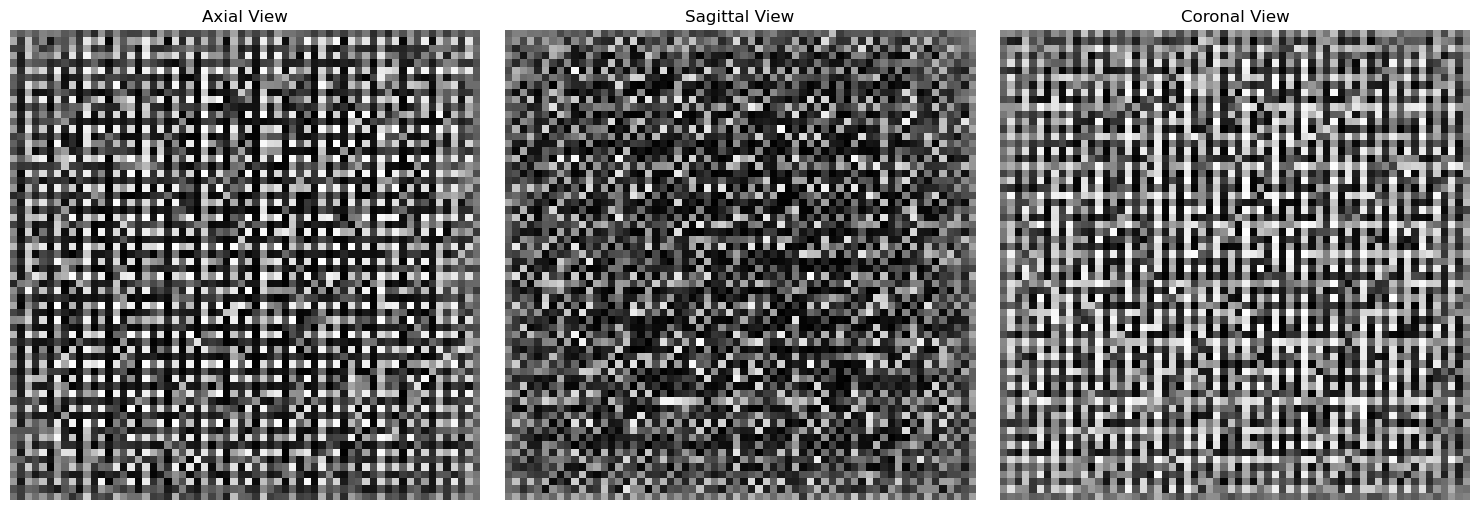

⚠️ Note: The model is currently untrained. The output represents the initial random weights initialization (noise).
✅ Generation successful. Output volume shape: (64, 64, 64)


In [3]:
# -*- coding: utf-8 -*-
'''
Author: Teresa Zorzi
Date: January 2026
'''

import torch
import matplotlib.pyplot as plt
import sys
import os

# Add project root to path to allow importing from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.models import CPUOptimizedGenerator3D 

def show_generated_brain():
    """
    Initializes the Generator, creates a random latent vector AND A LABEL, 
    and visualizes the output (synthetic brain volume).
    """
    
    # 1. Parameter Configuration
    LATENT_DIM = 64  # Must match the default in models.py
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 2. Initialize Generator
    # Note: Using defaults defined in the class (latent_dim=64)
    netG = CPUOptimizedGenerator3D(latent_dim=LATENT_DIM).to(device)
    netG.eval() # Set to evaluation mode
    
    # 3. Prepare inputs
    # Latent Vector Z (Batch=1, Dim=64)
    z = torch.randn(1, LATENT_DIM).to(device) 
    
    # Fake label (e.g., class 0 = AD/Alzheimer's)
    fake_label = torch.tensor([0], dtype=torch.long).to(device)
    
    # 4. Generate image (Passing Z and LABEL)
    with torch.no_grad():
        fake_brain = netG(z, fake_label).cpu().squeeze().numpy() 
    
    # 5. Visualize central slices
    mid_slice = 32
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Axial View
    axes[0].imshow(fake_brain[mid_slice, :, :], cmap='gray')
    axes[0].set_title("Axial View")
    axes[0].axis('off')
    
    # Sagittal View
    axes[1].imshow(fake_brain[:, mid_slice, :], cmap='gray')
    axes[1].set_title("Sagittal View")
    axes[1].axis('off')
    
    # Coronal View
    axes[2].imshow(fake_brain[:, :, mid_slice], cmap='gray')
    axes[2].set_title("Coronal View")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("⚠️ Note: The model is currently untrained. The output represents the initial random weights initialization (noise).")
    print(f"✅ Generation successful. Output volume shape: {fake_brain.shape}")
# Run visualization
if __name__ == "__main__":
    show_generated_brain()